# Домашнє завдання до модуля «Підходи до покращення якості»

In [9]:
import pickle
import pandas as pd
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Завантажуємо набір даних Autos

In [2]:
with open('../datasets/mod_05_topic_10_various_data.pkl', 'rb') as fl:
    datasets = pickle.load(fl)

autos = datasets['autos']
autos.head()

,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,width,height,curb_weight,engine_type,num_of_cylinders,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,4,130,mpfi,3.47,2.68,9,111,5000,21,27,13495
1,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,4,130,mpfi,3.47,2.68,9,111,5000,21,27,16500
2,alfa-romero,gas,std,2,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,6,152,mpfi,2.68,3.47,9,154,5000,19,26,16500
3,audi,gas,std,4,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,4,109,mpfi,3.19,3.40,10,102,5500,24,30,13950
4,audi,gas,std,4,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,5,136,mpfi,3.19,3.40,8,115,5500,18,22,17450


## 2. Визначаємо дискретні ознаки

#### Категоріальні ознаки

In [3]:
cat_features = autos.select_dtypes(include=['object']).columns.tolist()

#### Дискретні числові ознаки

In [4]:
num_features = ['num_of_doors', 'num_of_cylinders']

#### Об'єднуємо дискретні ознаки

In [5]:
discrete_features = cat_features + num_features
discrete_features

['make',
 'fuel_type',
 'aspiration',
 'body_style',
 'drive_wheels',
 'engine_location',
 'engine_type',
 'fuel_system',
 'num_of_doors',
 'num_of_cylinders']

## 3. Розраховуємо показник взаємної інформації для вхідних ознак і цільової змінної price

#### Створюємо копію DataFrame та виділяємо цільову змінну

In [6]:
X = autos.copy()
y = X.pop('price')

#### Перетворюємо категоріальні ознаки у числові

In [7]:
for colname in cat_features:
    X[colname], _ = X[colname].factorize()

#### Обчислюємо взаємну інформацію MI Scores

In [8]:
mi_scores = mutual_info_regression(
    X, y,
    discrete_features=X.columns.isin(discrete_features),
    random_state=42)

mi_scores = pd.Series(mi_scores, name='MI Scores', index=X.columns).sort_values()

mi_scores.sample(5)

engine_location     0.036912
horsepower          0.891165
num_of_cylinders    0.330589
fuel_type           0.047298
peak_rpm            0.234449
Name: MI Scores, dtype: float64

## 4. Будуємо регресійну модель для оцінки важливості ознак

#### Будуємо модель за допомогою GradientBoostingRegressor

In [10]:
X_train, X_test, y_train, y_test = train_test_split(autos.drop(columns='price'), autos['price'], test_size=0.2, random_state=42)

encoder = ce.TargetEncoder(cols=cat_features)
X_train = encoder.fit_transform(X_train, y_train)
X_test = encoder.transform(X_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = GradientBoostingRegressor(random_state=42)
model.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

#### Обчислюємо оцінку важливості ознак GB Scores

In [11]:
gb_scores = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

gb_scores.sample(5)

drive_wheels    0.001982
num_of_doors    0.000009
peak_rpm        0.002028
body_style      0.003959
horsepower      0.044331
dtype: float64

## 5. Масштабуємо/уніфікуємо показники MI Scores та GB Scores

In [12]:
importance_df = pd.DataFrame({
    'MI Scores': mi_scores,
    'GB Scores': gb_scores
})

importance_df = importance_df.rank(pct=True)

importance_df.sample(5)

,MI Scores,GB Scores
length,0.739130,0.652174
drive_wheels,0.434783,0.391304
make,0.652174,1.000000
stroke,0.521739,0.260870
city_mpg,0.826087,0.608696


## 6. Будуємо візуалізацію типу grouped barsplots

#### Переформатуємо дані

In [13]:
importance_melted = importance_df.reset_index().melt(id_vars='index', var_name='variable', value_name='value')

#### Сортуємо ознаки за зменшенням MI Scores

In [15]:
importance_melted['MI_Scores_Rank'] = importance_melted[importance_melted['variable'] == 'MI Scores']['value']
importance_melted = importance_melted.sort_values('MI_Scores_Rank', ascending=False).drop(columns='MI_Scores_Rank')

#### Візуалізуємо ознаки

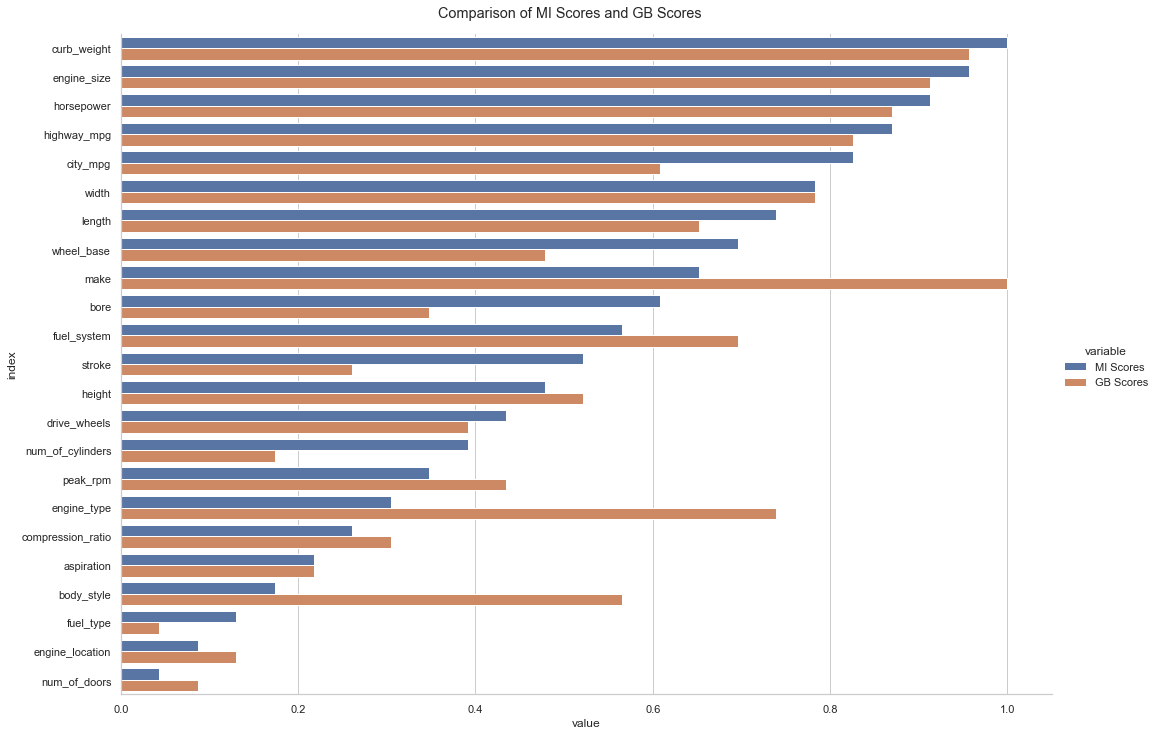

In [16]:
sns.set(style="whitegrid")
g = sns.catplot(
    data=importance_melted,
    kind='bar',
    x='value',
    y='index',
    hue='variable',
    height=10,
    aspect=1.5
)
g.fig.suptitle('Comparison of MI Scores and GB Scores', y=1.02)

plt.show()

## 7. Висновки

- Високі MI Scores та висока важливість ознак: Ознаки з високими значеннями обох метрик є найінформативнішими для моделі. Наприклад, curb_weight, engine_size, horsepower, highway_mpg мають високі показники як за MI Scores, так і за GB Scores.
- Розбіжності між MI Scores та важливістю ознак: Є кілька ознак, де значення MI Scores високі, але важливість за моделлю низька, або навпаки. Наприклад, make має високу важливість за моделлю, але низький MI Score, що може вказувати на те, що модель використовує цю ознаку у спосіб, який не відображений у взаємній інформації.
- Ознаки з низькими значеннями: Ознаки як num_of_doors та engine_location мають низькі значення обох метрик, що може свідчити про їхню низьку інформативність для моделі.

Підсумовуючи, аналіз групованих стовпчикових діаграм дозволяє ідентифікувати найважливіші ознаки, виявити розбіжності між різними метриками та запропонувати стратегії для подальшого покращення моделі.